### Read data from wikipedia page

In [205]:
import pandas as pd
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df=tables[0]

In [206]:
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [207]:
# size of dataframe before cleaning
df.shape

(180, 3)

### Data cleaning

In [208]:
# leave cells only with assigned burrows
df_clean=df[df['Borough']!='Not assigned']

df_clean.sort_values(by='Postal Code', inplace=True)
# reset index after dropping row
df_clean.reset_index(drop=True, inplace=True)


C:\Users\Mindaugas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [209]:
# check if there are any areas with unassigned neighbourhouds
df_clean[df_clean['Neighbourhood']==df_clean['Borough']].shape

(0, 3)

There are now such areas, therefore data cleaning is finished !

In [210]:
# cleaned dataframe
df_clean.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [211]:
# Number of rows in cleaned dataframe
df_clean.shape[0]

103

### Assign coordinates

In [212]:
# read data from csv file
df_coord = pd.read_csv('Geospatial_Coordinates.csv')
df_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [218]:
# Assign coordinates to areas
df_clean['Latitude']=df_coord['Latitude']
df_clean['Longitude']=df_coord['Longitude']
df_clean.head()

C:\Users\Mindaugas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Mindaugas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Clustering

Count the number of areas in each borough.

In [219]:
df_clean.groupby('Borough')['Borough'].count()

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Borough, dtype: int64

Seems like the North York has the highest number of neighbourhoods, so lets select it for our further analysis !

In [220]:
# select only neighbourhood from Norh York
toronto_data = df_clean[df_clean['Borough'] == 'North York'].reset_index(drop=True)
toronto_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M2H,North York,Hillcrest Village,43.803762,-79.363452
1,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
2,M2K,North York,Bayview Village,43.786947,-79.385975
3,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714
4,M2M,North York,"Willowdale, Newtonbrook",43.789053,-79.408493


Foursquare credentials (hidden)

In [221]:
CLIENT_ID = 'KP0R3JODDTYWNTWRFQVP5HJF4M4RW4LYIMK1M2BRACLI2FHX' # your Foursquare ID
CLIENT_SECRET = 'MQMXU505US2M1NM0UQMNLGZBWIOD3CVN0R5IPVO430IMVQLH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Extract data, as in New York example

In [222]:
toronto_data.loc[0, 'Neighbourhood']
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = toronto_data.loc[0, 'Neighbourhood'] # neighborhood name

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))


Latitude and longitude values of Hillcrest Village are 43.8037622, -79.3634517.


Import some libraries

In [223]:
import numpy as np # library to handle data in a vectorized manner


import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [224]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f1daa78a2bad162cf149e60'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 21,
  'suggestedBounds': {'ne': {'lat': 43.81276220900001,
    'lng': -79.35100467075661},
   'sw': {'lat': 43.79476219099999, 'lng': -79.37589872924339}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd9842be914a593adbd56fa',
       'name': 'Tastee',
       'location': {'address': '3913 Don Mills Rd.',
        'crossStreet': 'at Cliffwood Rd.',
        'lat': 43.80772211146167,
        'lng': -79.35679781099806,
        'labeledLatLngs': [{'label': 'display',
      

In [225]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Tastee,Bakery,43.807722,-79.356798
1,고려삼계탕 Korean Ginseng Chicken Soup & Bibimbap,Korean Restaurant,43.798391,-79.369187
2,Cummer Park,Park,43.799564,-79.371175
3,Galati,Grocery Store,43.797831,-79.369410
4,Tim Hortons,Coffee Shop,43.798945,-79.369644


In [165]:
radius=1000
LIMIT=50

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [226]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Bedford Park, Lawrence Manor East
Lawrence Manor, Lawrence Heights
Glencairn
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Humberlea, Emery


#### Let's count the number of selected venues in each neighbourhood.

In [166]:
venues_count = toronto_venues.groupby('Neighborhood')['Neighborhood'].count()
venues_count

Neighborhood
Bathurst Manor, Wilson Heights, Downsview North    21
Bayview Village                                     4
Bedford Park, Lawrence Manor East                  25
Don Mills                                          26
Downsview                                          15
Fairview, Henry Farm, Oriole                       50
Glencairn                                           5
Hillcrest Village                                   5
Humber Summit                                       1
Humberlea, Emery                                    2
Lawrence Manor, Lawrence Heights                   11
North Park, Maple Leaf Park, Upwood Park            6
Northwood Park, York University                     8
Parkwoods                                           2
Victoria Village                                    4
Willowdale, Newtonbrook                             1
Willowdale, Willowdale East                        34
Willowdale, Willowdale West                         6
York Mills West

### Clustering of neighbourhoods based on the number of found venues

We'll use k-neighbours clustering. To find the best number of clusters we'll use silhouette coefficient.

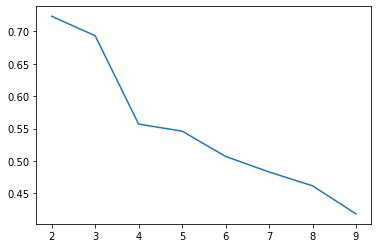

In [227]:
# number of venues reshaped as an array for clustering
X=np.array(venues_count).reshape(-1,1)

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
scores=[]
for k in range(2,10):
    knn = KMeans(n_clusters=k, random_state=9).fit(X)
    scores.append(silhouette_score(X, knn.labels_))

plt.plot(range(2,10),scores) 
plt.show()

Using the elbow method it seasm that 4 is a suitable number of clusters. Let's retrain the model using k = 4.

In [228]:
knn = KMeans(n_clusters=4, random_state=9).fit(X)

#### Add cluster labels 

In [229]:
toronto_data.sort_values(by='Neighbourhood',inplace=True)
new_df=pd.DataFrame({'Neighbourhood':venues_count.index, 'Cluster': knn.labels_})
toronto_data=pd.merge(toronto_data,new_df,on='Neighbourhood')
toronto_data.head()


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster
0,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,1
1,M2K,North York,Bayview Village,43.786947,-79.385975,3
2,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,1
3,M3B,North York,Don Mills,43.745906,-79.352188,1
4,M3C,North York,Don Mills,43.725900,-79.340923,1


## Creating the map

In [235]:
latitude=43.7615
longitude=-79.4111
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood'], toronto_data['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters